# Imports

In [1]:
import arviz as az
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

from data_collection.nwi_cities import NWI_CITIES

# Data Extraction

In [2]:
FAST_FOOD_PERCENTAGES = np.array([city_data['fast_food_percentage'] for city_data in NWI_CITIES.values()])  # Fast-food percentages
MEDIAN_INCOMES = np.array([city_data['median_income'] for city_data in NWI_CITIES.values()])  # Median incomes

# Standardizing the data
ffp_standardized = (FAST_FOOD_PERCENTAGES - np.mean(FAST_FOOD_PERCENTAGES)) / np.std(FAST_FOOD_PERCENTAGES)
mi_standardized = (MEDIAN_INCOMES - np.mean(MEDIAN_INCOMES)) / np.std(MEDIAN_INCOMES)



# Model

In [15]:
with pm.Model() as income_model:
    # Data
    x_data = pm.Data("x_data", ffp_standardized)
    y_data = pm.Data("y_data", mi_standardized)

    # Priors
    intercept = pm.Normal('Intercept', mu=0, sigma=10)
    beta = pm.Normal('Beta', mu=0, sigma=10)
    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)

    # Linear model
    mu = intercept + beta * x_data

    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, tau=tau, observed=y_data)

    # Posterior sampling
    trace = pm.sample(3000, target_accept=0.95)

/Users/adamcuculich/georgia-tech/bayesian-stats/env/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, Beta, Intercept]


/Users/adamcuculich/georgia-tech/bayesian-stats/env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/adamcuculich/georgia-tech/bayesian-stats/env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/adamcuculich/georgia-tech/bayesian-stats/env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/adamcuculich/georgia-tech/bayesian-stats/env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.


# Statistical Summary

In [16]:
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/adamcuculich/georgia-tech/bayesian-stats/env/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.003,0.196,-0.377,0.361,0.002,0.002,10212.0,7819.0,1.0
Beta,-0.394,0.197,-0.767,-0.031,0.002,0.001,10047.0,7469.0,1.0
tau,1.101,0.318,0.540,1.689,0.003,0.002,9450.0,8269.0,1.0


# Visualization

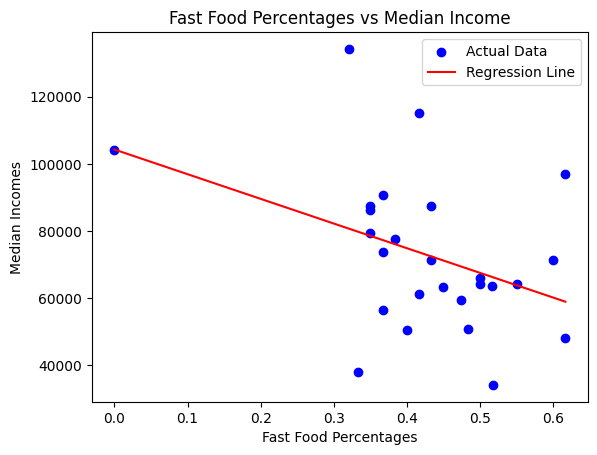

In [18]:
# Define the function to calculate the original scale predictions
def predict_original_scale(x_range, intercept, beta, x_mean, x_std, y_mean, y_std):
    x_standardized = (x_range - x_mean) / x_std
    y_standardized_pred = intercept + beta * x_standardized
    y_pred_original = y_standardized_pred * y_std + y_mean
    return y_pred_original

# Calculate the regression line based on the posterior mean of the parameters
intercept_mean = np.mean(trace['Intercept'])
beta_mean = np.mean(trace['Beta'])

# The means and standard deviations used for standardizing the data
x_mean = np.mean(FAST_FOOD_PERCENTAGES)
x_std = np.std(FAST_FOOD_PERCENTAGES)
y_mean = np.mean(MEDIAN_INCOMES)
y_std = np.std(MEDIAN_INCOMES)

# Generate the regression line in the original scale
x_range_original = np.linspace(FAST_FOOD_PERCENTAGES.min(), FAST_FOOD_PERCENTAGES.max(), 100)
y_pred_original = predict_original_scale(x_range_original, intercept_mean, beta_mean, x_mean, x_std, y_mean, y_std)

# Plot the actual data
plt.scatter(FAST_FOOD_PERCENTAGES, MEDIAN_INCOMES, color='blue', label='Actual Data')

# Plot the regression line
plt.plot(x_range_original, y_pred_original, color='red', label='Regression Line')

# Labels and legend
plt.xlabel('Fast Food Percentages')
plt.ylabel('Median Incomes')
plt.title('Fast Food Percentages vs Median Income')
plt.legend()
plt.show()